In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
# %cd CD_Circuit/

import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals, compare_same
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer


## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [5]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=3, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)
mean_acts.shape

2024-09-17 21:17:04.200682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 21:17:09.445752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([12, 16, 768])

In [10]:
len(ioi_dataset.io_tokenIDs)

50

In [5]:
logits, cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension
l = logits.cpu().numpy()


In [6]:

# source_list = [Node(0, 0, 0), Node(1, 1, 1)]
# target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
# out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

## Ablating last layer and determining value of irrel

In [27]:
import functools
ranges = [
        [layer for layer in range(11, 12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [tuple(n for n in source_nodes)] # here, note ablation set is a single set consisting of all source nodes in (ranges)

target_nodes = []
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

print("rel norm: ", np.linalg.norm(out_decomp[0].rel))
print("irrel norm: ", np.linalg.norm(out_decomp[0].irrel)) # should be zero, but is not

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

# prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
# out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

rel norm:  3120.5266
irrel norm:  0.0


## Generate heatmap of (attn_head, layer_idx) relevance to logits at different sequence positions 

180
Running inputs 0 to 64 (of 180)
Running inputs 64 to 128 (of 180)
Running inputs 128 to 180 (of 180)


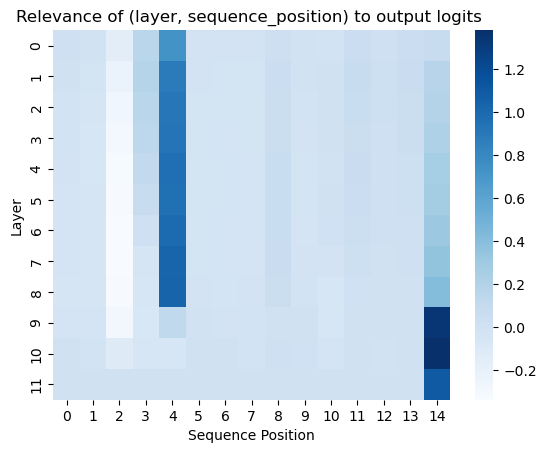

In [9]:
import functools
# ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
'''
ranges = [
        [layer for layer in range(12)], 
        [sequence_position for sequence_position in range(15)], # note fixed to last sequence position
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
target_nodes = []
'''
ablation_sets = []
for l in range(12):
    for s in range(15):
        ablation_sets.append(tuple(Node(l, s, head) for head in range(12)))
#ablation_sets = list[(Node(l, s, head) for head in range(12)) for l in range(12) for s in range(15)]
print(len(ablation_sets))
target_nodes = []
# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit
assert(full_score > 0)
relevances = np.zeros((12, 15))
for layer_idx in range(12):
    for seq_idx in range(15):
        decomp = out_decomps[15 * layer_idx + seq_idx]
        rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
        rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
        relevances[layer_idx, seq_idx] = (rel_io_logit - rel_s_logit) / full_score
        # print(decomp.ablation_set[0], (rel_io_logit - rel_s_logit))

s = sns.heatmap(relevances, xticklabels = range(15), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Sequence Position', ylabel='Layer')
token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of (layer, sequence_position) to output logits ")
plt.show()


Running inputs 0 to 64 (of 2160)
Running inputs 64 to 128 (of 2160)
Running inputs 128 to 192 (of 2160)
Running inputs 192 to 256 (of 2160)
Running inputs 256 to 320 (of 2160)
Running inputs 320 to 384 (of 2160)
Running inputs 384 to 448 (of 2160)
Running inputs 448 to 512 (of 2160)
Running inputs 512 to 576 (of 2160)
Running inputs 576 to 640 (of 2160)
Running inputs 640 to 704 (of 2160)
Running inputs 704 to 768 (of 2160)
Running inputs 768 to 832 (of 2160)
Running inputs 832 to 896 (of 2160)
Running inputs 896 to 960 (of 2160)
Running inputs 960 to 1024 (of 2160)
Running inputs 1024 to 1088 (of 2160)
Running inputs 1088 to 1152 (of 2160)
Running inputs 1152 to 1216 (of 2160)
Running inputs 1216 to 1280 (of 2160)
Running inputs 1280 to 1344 (of 2160)
Running inputs 1344 to 1408 (of 2160)
Running inputs 1408 to 1472 (of 2160)
Running inputs 1472 to 1536 (of 2160)
Running inputs 1536 to 1600 (of 2160)
Running inputs 1600 to 1664 (of 2160)
Running inputs 1664 to 1728 (of 2160)
Running i

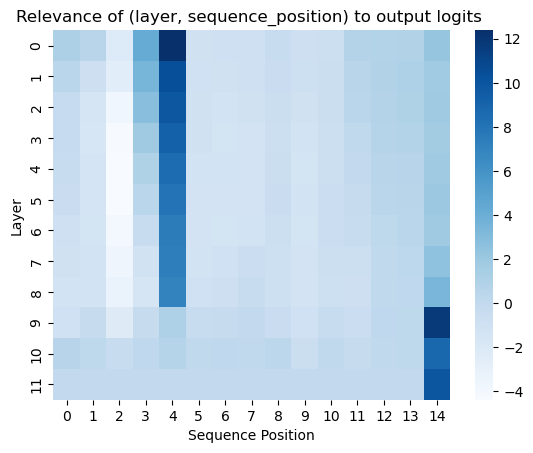

In [10]:
import functools
# ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
ranges = [
        [layer for layer in range(12)], 
        [sequence_position for sequence_position in range(15)], # note fixed to last sequence position
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
# ablation_sets = list[(Node(l, s, head) for head in range(12)) for l in range(12) for s in range(15)]
# print(len(ablation_sets))
target_nodes = []
# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
relevances_by_head = np.zeros((12, 15, 12))
for layer_idx in range(12):
    for seq_idx in range(15):
        for head_idx in range(12):
            decomp = out_decomps[15 * 12 * layer_idx + 12 * seq_idx + head_idx]
            rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
            rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
            relevances_by_head[layer_idx, seq_idx, head_idx] = rel_io_logit - rel_s_logit
sum_relevances = np.sum(relevances_by_head, axis=2)
print(sum_relevances.shape)
s = sns.heatmap(sum_relevances, xticklabels = range(15), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Sequence Position', ylabel='Layer')
token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of (layer, sequence_position) to output logits ")
plt.show()


In [11]:
print(relevances[0, 4]) # 1.758
print(relevances[9, 14]) # 4.304
print(relevances_by_head[0, 4, :]) 
print(relevances_by_head[9, 14, :])

0.7229364514350891
1.335706353187561
[0.90194058 1.32585776 0.72544396 0.70231342 1.22731268 1.24055517
 1.47584224 0.81058383 1.10344589 1.03122199 0.86059272 0.98422921]
[0.91697133 0.62106657 1.13248563 0.7433517  0.58547711 0.49030435
 1.62917924 0.25455964 0.96564209 3.21997523 0.55443633 0.6060456 ]


In [37]:
print(relevances[11, 14]) # 4.304


0.969648540019989


In [13]:
for i in range(9):
    print(sum_relevances[i, 4])
for i in range(9, 12):
    print(sum_relevances[i, 14]) 

12.389339447021484
10.377024412155151
9.842657506465912
9.209005236625671
8.504498302936554
8.005799353122711
7.543103456497192
7.351645886898041
7.0622512102127075
11.719494819641113
8.80651342868805
9.91090476512909


180


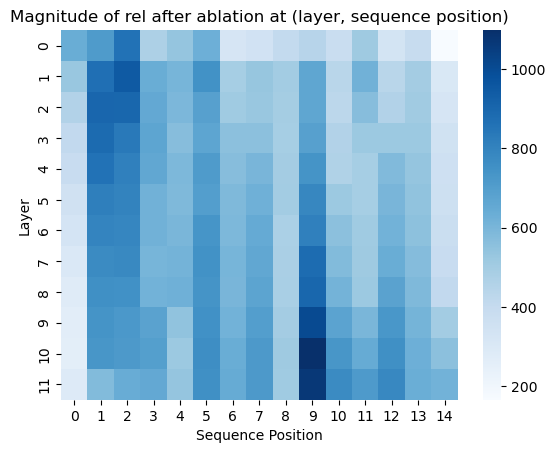

In [49]:
import functools
# ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
'''
ranges = [
        [layer for layer in range(12)], 
        [sequence_position for sequence_position in range(15)], # note fixed to last sequence position
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
target_nodes = []
'''
ablation_sets = []
for l in range(12):
    for s in range(15):
        ablation_sets.append(tuple(Node(l, s, head) for head in range(12)))
#ablation_sets = list[(Node(l, s, head) for head in range(12)) for l in range(12) for s in range(15)]
print(len(ablation_sets))
target_nodes = []
# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
# logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
# io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
# s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
# full_score = io_logit - s_logit
# assert(full_score > 0)
relevances = np.zeros((12, 15))
for layer_idx in range(12):
    for seq_idx in range(15):
        decomp = out_decomps[15 * layer_idx + seq_idx]
        
        relevances[layer_idx, seq_idx] = np.linalg.norm(decomp.rel)
        # print(decomp.ablation_set[0], (rel_io_logit - rel_s_logit))

s = sns.heatmap(relevances, xticklabels = range(15), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Sequence Position', ylabel='Layer')
token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Magnitude of rel after ablation at (layer, sequence position)")
plt.show()


In [45]:
print(relevances)

[[ 636.54058838  710.81530762  860.20629883  472.4883728   534.86846924
   627.82550049  325.55905151  347.95544434  408.46627808  444.15985107
   386.80667114  513.46759033  334.08065796  392.24581909  166.2756958 ]
 [ 527.33032227  871.01190186  947.39807129  635.72943115  603.73455811
   748.25152588  493.22045898  530.15527344  501.63265991  666.90484619
   435.95046997  619.49633789  438.77001953  497.49642944  305.27816772]
 [ 459.72610474  903.55047607  900.00482178  655.05700684  591.95025635
   688.44342041  511.61016846  527.3291626   495.6552124   666.91821289
   430.82272339  568.79016113  457.51031494  506.05752563  325.12722778]
 [ 412.80563354  884.08880615  837.05731201  671.59960938  569.81970215
   670.07214355  558.54064941  558.90057373  492.97216797  688.28485107
   459.90591431  522.49432373  521.47930908  522.14807129  349.48669434]
 [ 389.69326782  858.93243408  811.3840332   659.80517578  589.1998291
   708.79858398  568.60791016  601.20996094  497.74954224  73

In [6]:
import functools
# ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
ranges = [
        [layer for layer in range(12)], 
        [sequence_position for sequence_position in range(15)], # note fixed to last sequence position
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
# ablation_sets = list[(Node(l, s, head) for head in range(12)) for l in range(12) for s in range(15)]
# print(len(ablation_sets))
target_nodes = []
# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
# print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...



Running inputs 0 to 64 (of 2160)
Running inputs 64 to 128 (of 2160)
Running inputs 128 to 192 (of 2160)
Running inputs 192 to 256 (of 2160)
Running inputs 256 to 320 (of 2160)
Running inputs 320 to 384 (of 2160)
Running inputs 384 to 448 (of 2160)
Running inputs 448 to 512 (of 2160)
Running inputs 512 to 576 (of 2160)
Running inputs 576 to 640 (of 2160)
Running inputs 640 to 704 (of 2160)
Running inputs 704 to 768 (of 2160)
Running inputs 768 to 832 (of 2160)
Running inputs 832 to 896 (of 2160)
Running inputs 896 to 960 (of 2160)
Running inputs 960 to 1024 (of 2160)
Running inputs 1024 to 1088 (of 2160)
Running inputs 1088 to 1152 (of 2160)
Running inputs 1152 to 1216 (of 2160)
Running inputs 1216 to 1280 (of 2160)
Running inputs 1280 to 1344 (of 2160)
Running inputs 1344 to 1408 (of 2160)
Running inputs 1408 to 1472 (of 2160)
Running inputs 1472 to 1536 (of 2160)
Running inputs 1536 to 1600 (of 2160)
Running inputs 1600 to 1664 (of 2160)
Running inputs 1664 to 1728 (of 2160)
Running i

(12, 15)


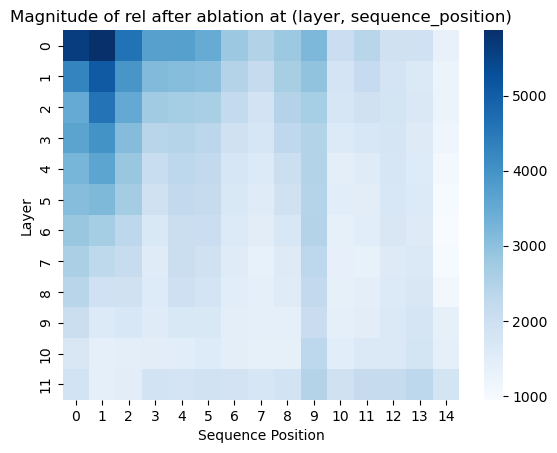

In [7]:
relevances_by_head = np.zeros((12, 15, 12))
for layer_idx in range(12):
    for seq_idx in range(15):
        for head_idx in range(12):
            decomp = out_decomps[15 * 12 * layer_idx + 12 * seq_idx + head_idx]

            relevances_by_head[layer_idx, seq_idx, head_idx] = np.linalg.norm(decomp.rel)
sum_relevances = np.sum(relevances_by_head, axis=2)
print(sum_relevances.shape)
s = sns.heatmap(sum_relevances, xticklabels = range(15), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Sequence Position', ylabel='Layer')
token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Magnitude of rel after ablation at (layer, sequence_position)")
plt.show()


(12, 15)


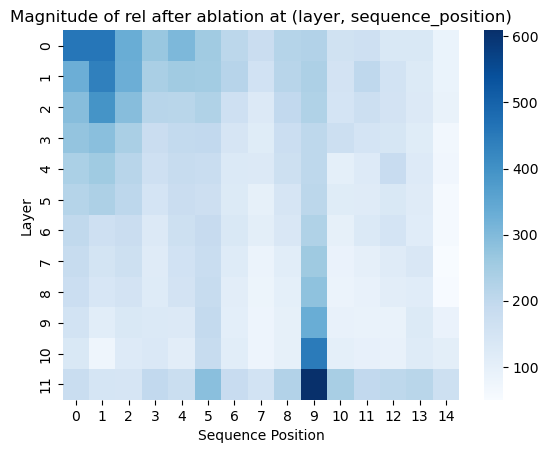

(12, 15)


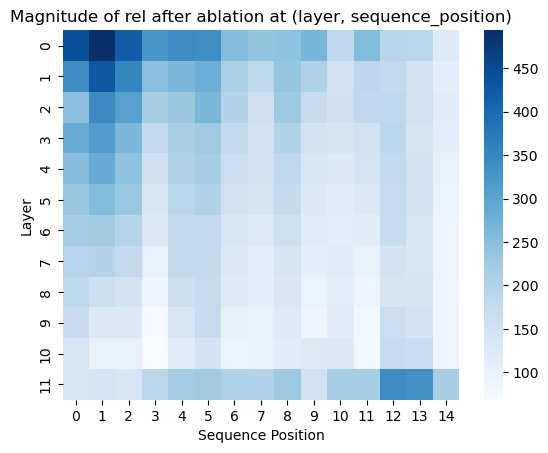

(12, 15)


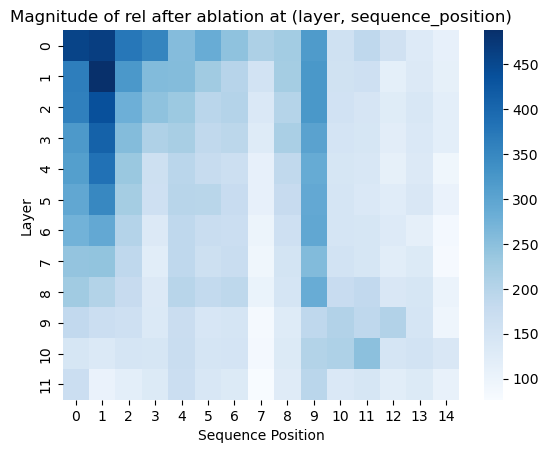

(12, 15)


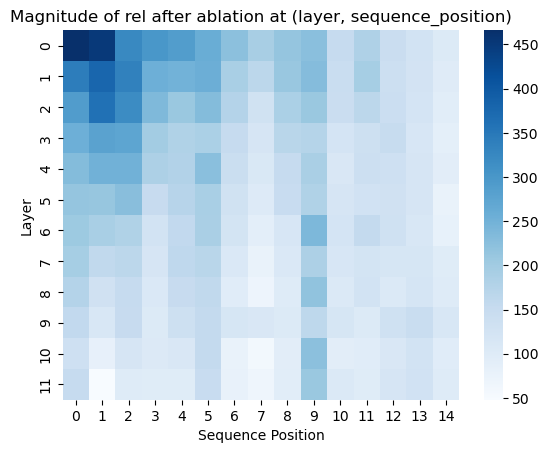

(12, 15)


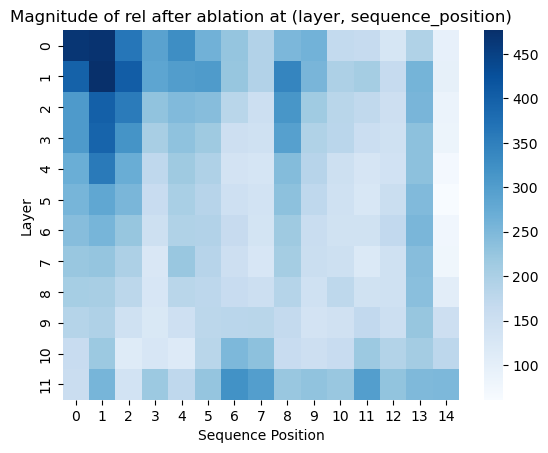

(12, 15)


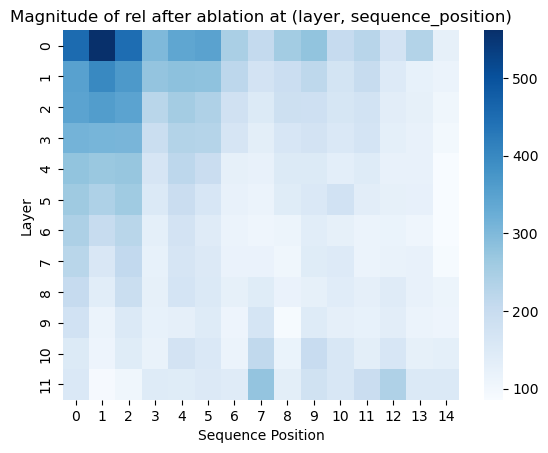

(12, 15)


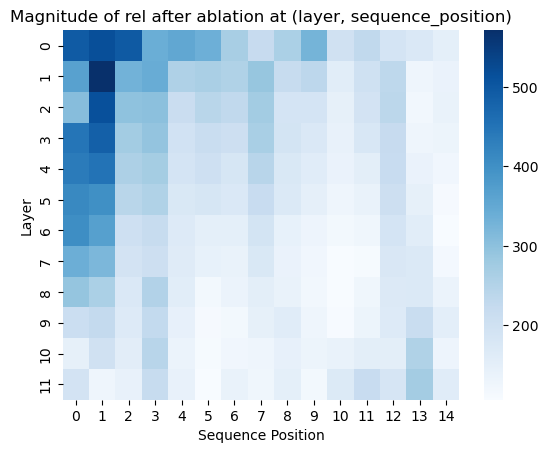

(12, 15)


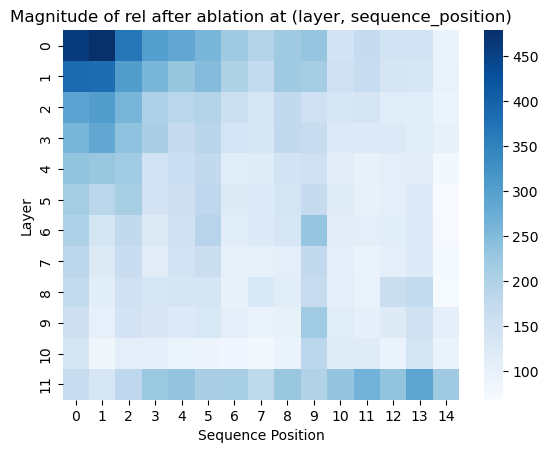

(12, 15)


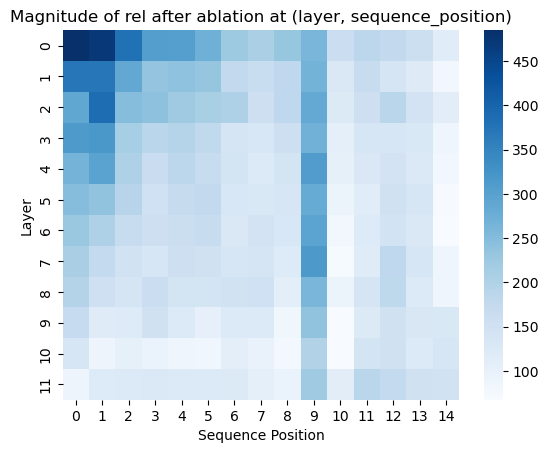

(12, 15)


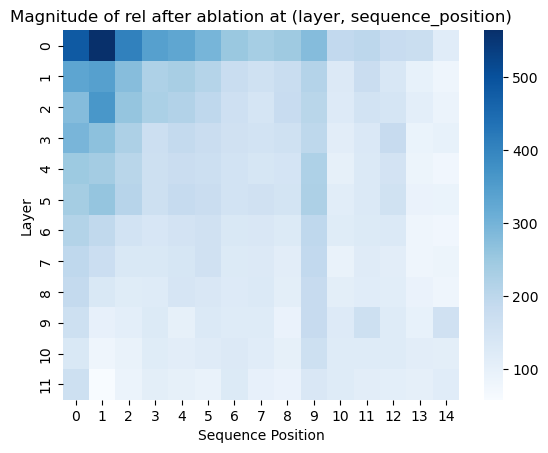

(12, 15)


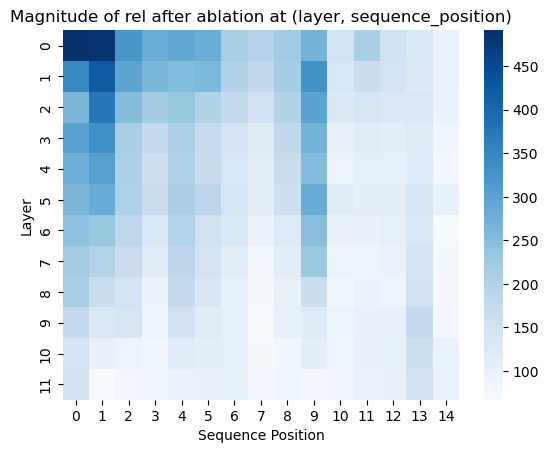

(12, 15)


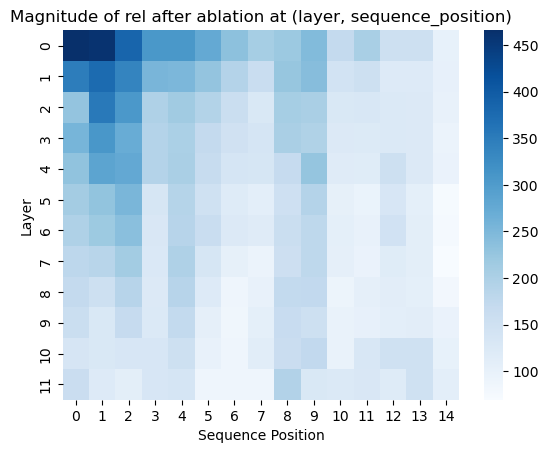

In [8]:
for head_idx in range(12):
    sum_relevances = relevances_by_head[:, :, head_idx]
    print(sum_relevances.shape)
    s = sns.heatmap(sum_relevances, xticklabels = range(15), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
    s.set(xlabel='Sequence Position', ylabel='Layer')
    token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
    plt.title("Magnitude of rel after ablation at (layer, sequence_position)")
    plt.show()

## Generate heatmap of (attn_head, layer_idx) relevance to logits at different sequence positions 

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


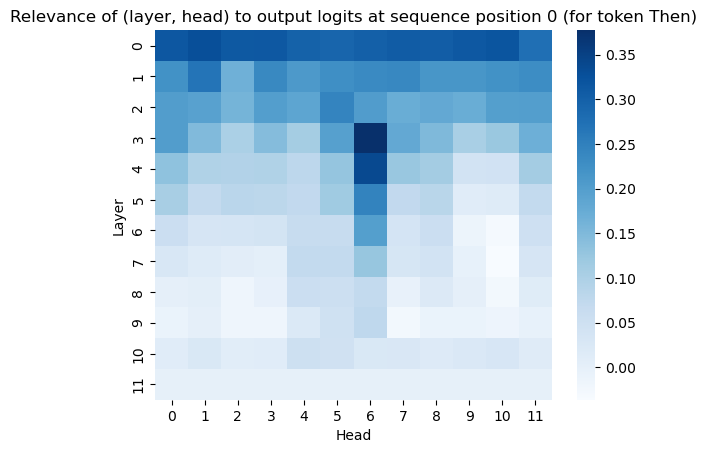

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


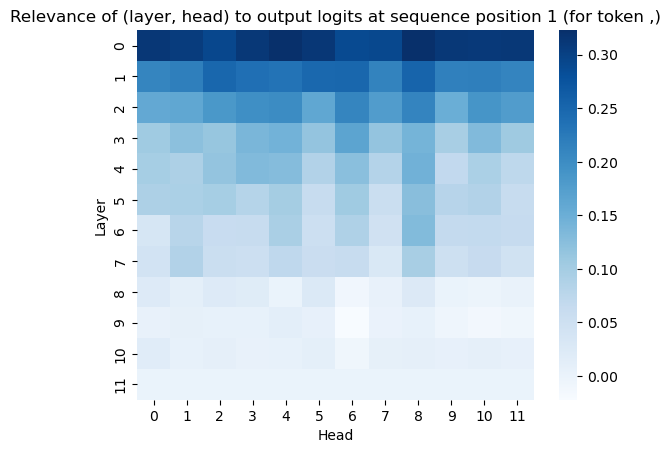

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


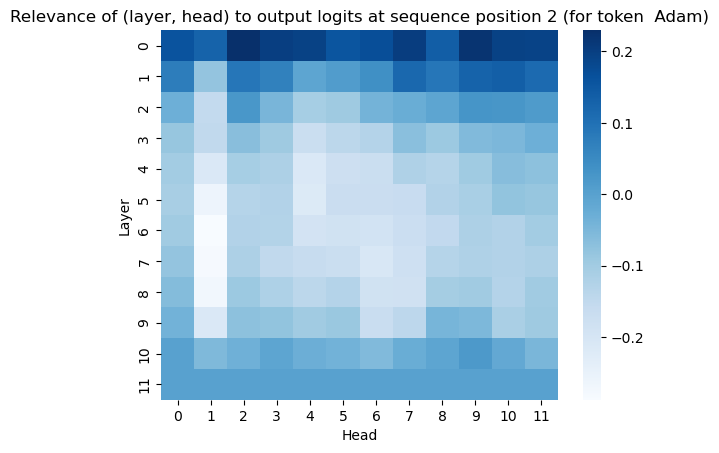

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


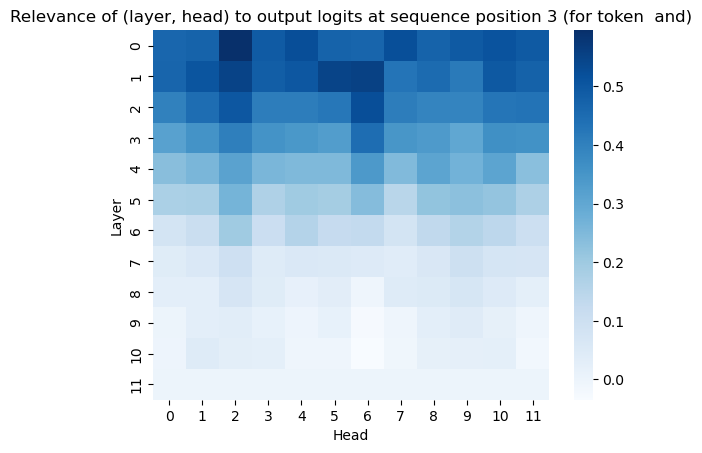

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


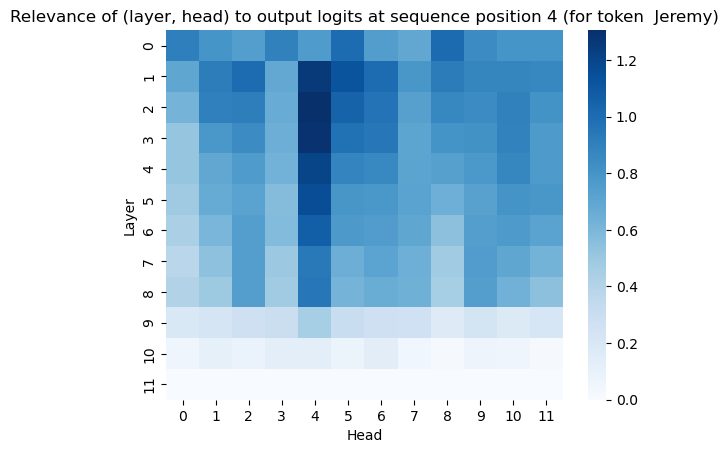

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


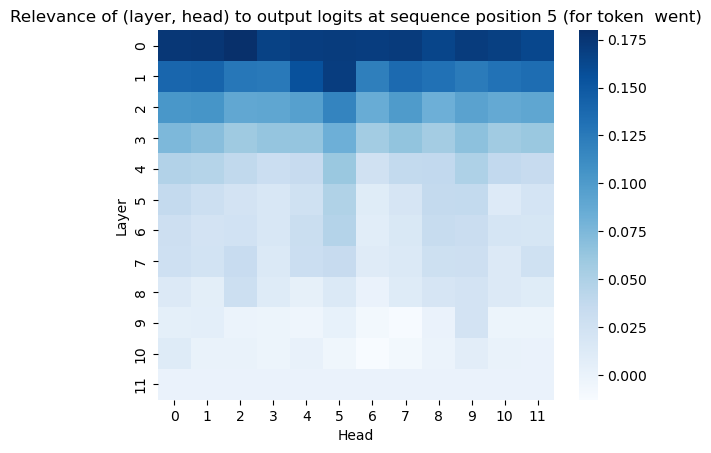

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


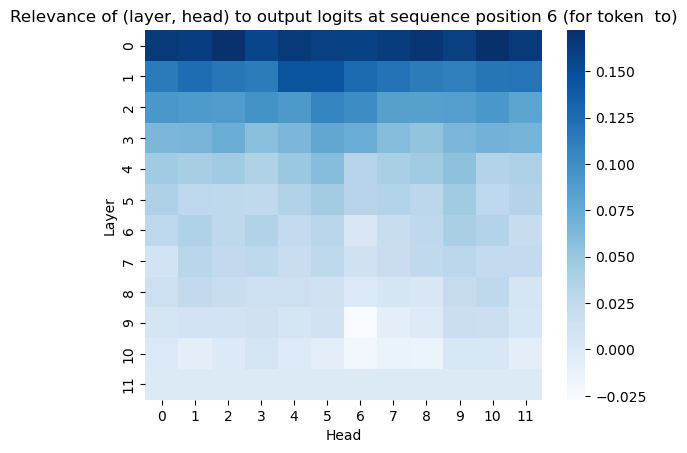

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


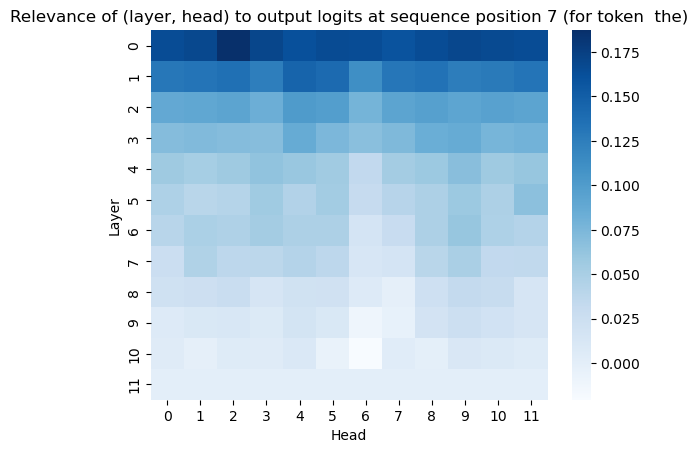

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


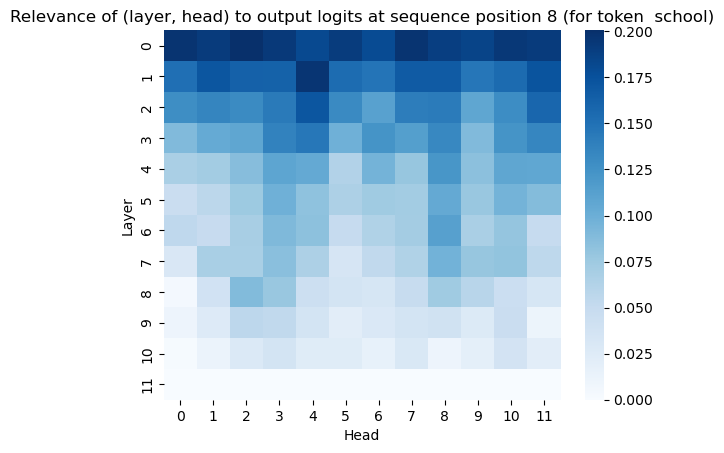

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


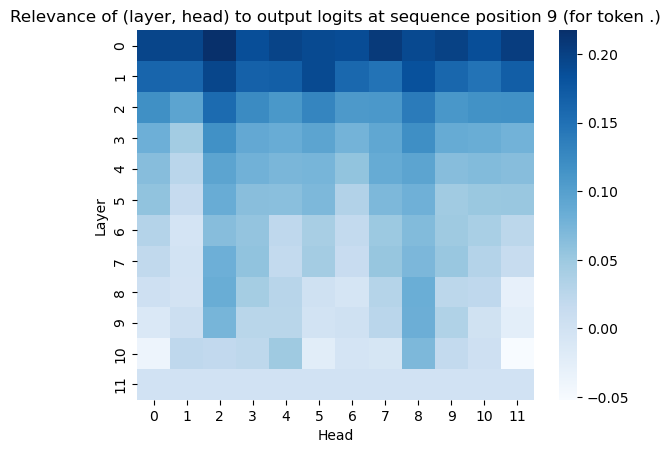

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


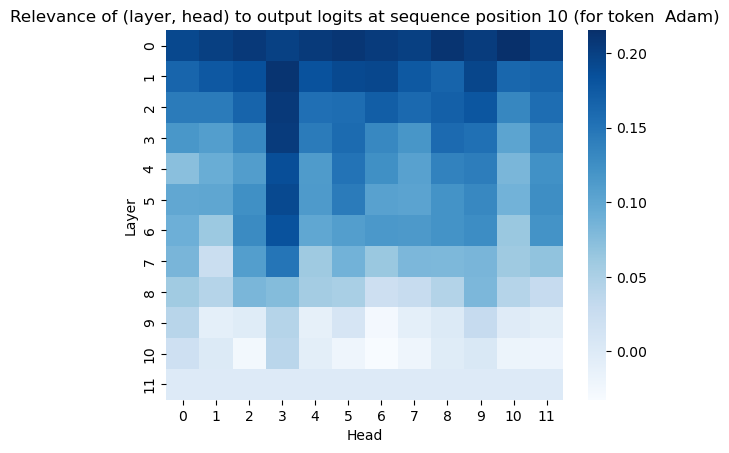

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


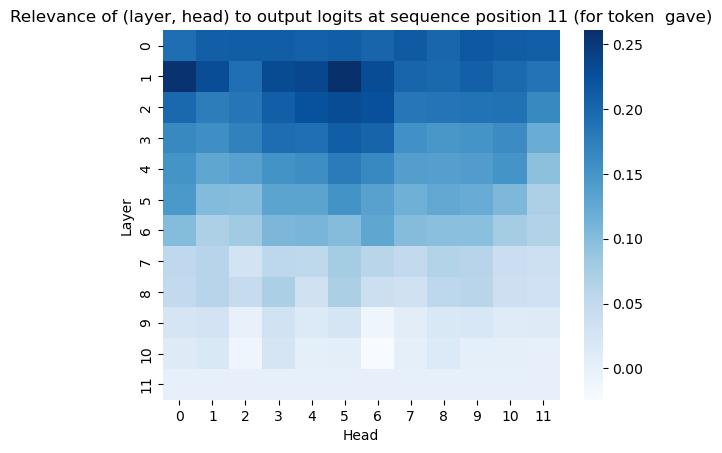

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


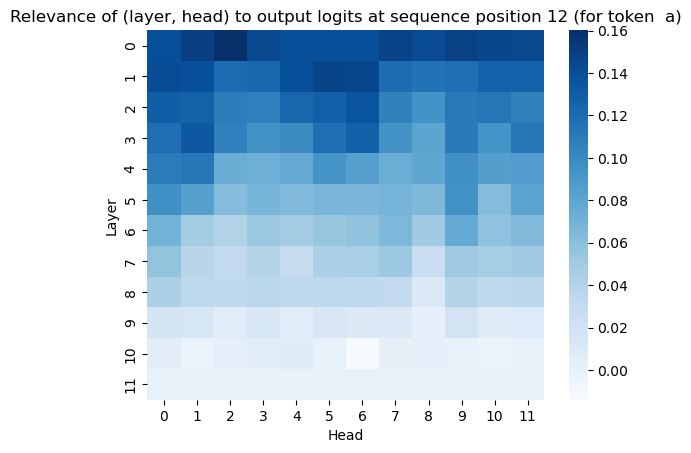

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


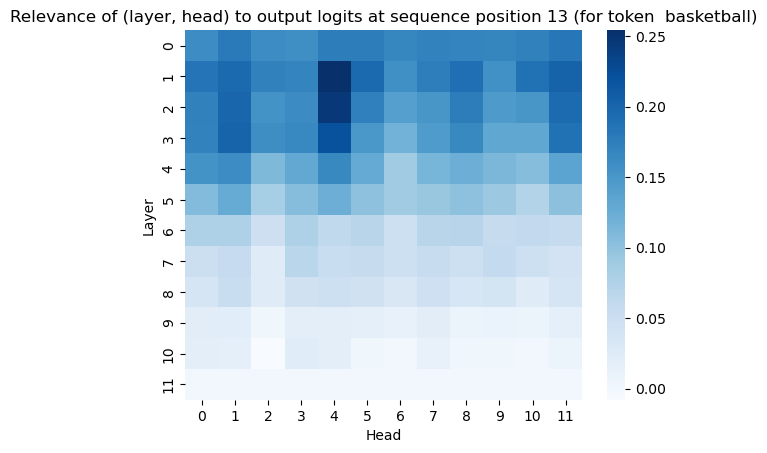

Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)


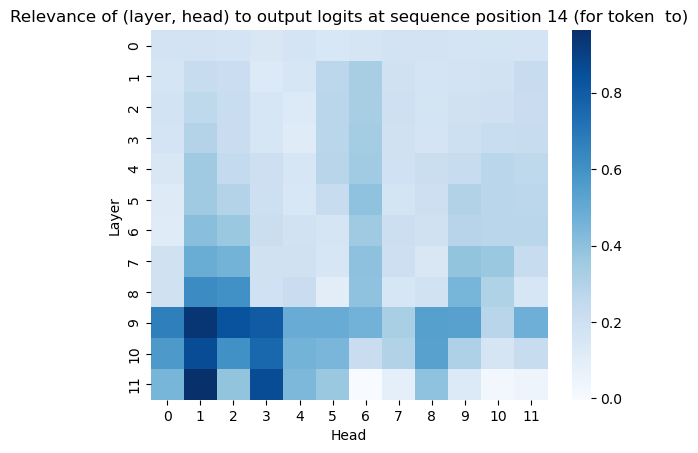

In [9]:
import functools
ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

for seq_idx in range(15):
    ranges = [
            [layer for layer in range(12)], 
            [sequence_position for sequence_position in range(seq_idx, seq_idx + 1)], # note fixed to last sequence position
            [attention_head_idx for attention_head_idx in range(12)]
        ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
    target_nodes = []
    # cache activations for faster batch run
    out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
    # print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
    relevances = np.zeros((12, 12))
    for layer_idx in range(12):
        for head_idx in range(12):
            decomp = out_decomps[12 * layer_idx + head_idx]
            rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
            rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
            relevances[layer_idx, head_idx] = rel_io_logit - rel_s_logit

    s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
    s.set(xlabel='Head', ylabel='Layer')
    token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
    plt.title("Relevance of (layer, head) to output logits at sequence position %d (for token %s)" % (seq_idx, token))
    plt.show()


Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144

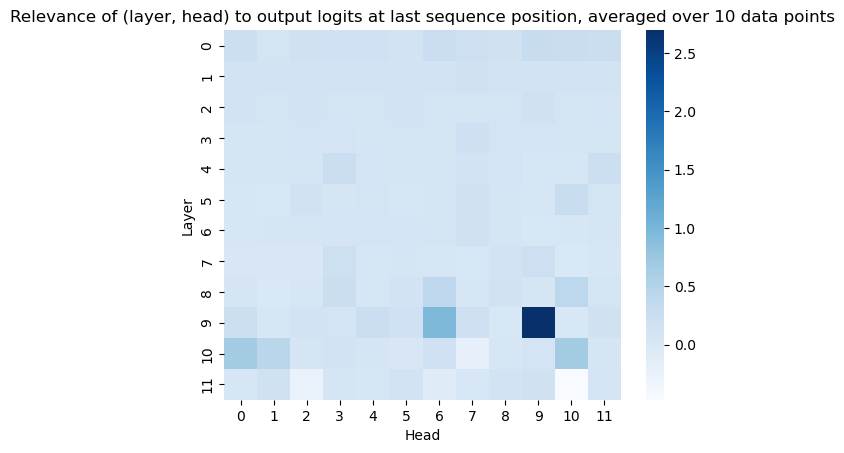

In [13]:
ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)
for i in range(10):
    text = ioi_dataset.sentences[i]
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                            device)

    ranges = [
            [layer for layer in range(12)], 
            [sequence_position for sequence_position in range(14, 15)], # note fixed to last sequence position
            [attention_head_idx for attention_head_idx in range(12)]
        ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
    target_nodes = []
    # cache activations for faster batch run
    out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
    # print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
    relevances = np.zeros((12, 12, 10))
    for layer_idx in range(12):
        for head_idx in range(12):
            decomp = out_decomps[12 * layer_idx + head_idx]
            rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[i]]
            rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[i]]
            relevances[layer_idx, head_idx, i] = rel_io_logit - rel_s_logit

s = sns.heatmap(np.sum(relevances, axis=2), xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of (layer, head) to output logits at last sequence position, averaged over 10 data points")
plt.show()

In [15]:
print(relevances[10, 7]) # 10, 7 and 11, 10 should be negative name mover heads, and so should have negative relevance

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.20274383]


Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144 (of 144)
Running inputs 0 to 64 (of 144)
Running inputs 64 to 128 (of 144)
Running inputs 128 to 144

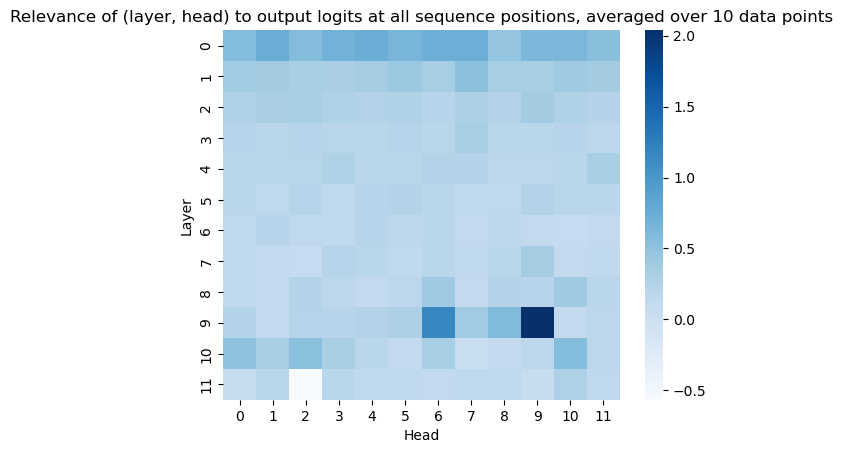

In [8]:
ioi_dataset = IOIDataset(prompt_type="mixed", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)
for i in range(10):
    text = ioi_dataset.sentences[i]
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                            device)
    '''
    ranges = [
            [layer for layer in range(12)], 
            [sequence_position for sequence_position in range(14, 15)], # note fixed to last sequence position
            [attention_head_idx for attention_head_idx in range(12)]
        ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
    '''
    ablation_sets = []
    for layer in range(12):
        for attention_head_idx in range(12):
            ablation_sets.append(tuple(Node(layer, x, attention_head_idx) for x in range(15)))
    target_nodes = []
    # cache activations for faster batch run
    out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
    # print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
    relevances = np.zeros((12, 12, 10))
    for layer_idx in range(12):
        for head_idx in range(12):
            decomp = out_decomps[12 * layer_idx + head_idx]
            rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[i]]
            rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[i]]
            relevances[layer_idx, head_idx, i] = rel_io_logit - rel_s_logit

s = sns.heatmap(np.sum(relevances, axis=2), xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of (layer, head) to output logits at all sequence positions, averaged over 10 data points")
plt.show()

## Find magnitude of rels at initialization

The key question right now is: why is the relevance of the s-inhibition heads so weak? (to the logits, and to the name mover heads)

The current idea is that the target attribution metric isn't any good.
But when trying to test this with different metrics, the results consistently give higher attribution scores to nodes in early layers.

However, it's also true that the rel-vector in the eventual decomposition has the same size for most nodes, so the particular relevance to e.g the IOI score is not a total coincedence.
Additionally, we're trying to ensure that we have no bugs, ie, that we are ablating the right things/replacing them with the right things.

Other notes: 

The ACDC paper "tries to delete as many nodes as possible" (but does counterfactual/causal mediation stuff in order to do so).
We are generally not separating direct effect from indirect effect, and need to modify the core algorithm in order to do so.
(Effects are more direct when they happen over a smaller number of layers. But measuring the direct effect to heads which are largely irrelevant, like the layer 11 heads, is also not what you want to do.)
(It is not clear that measuring mostly direct effect is what will get you a circuit. Try to understand the methodology of the IOI paper a little more thoroughly.)


If you think about what ablating the S-inhibition heads would do, it would definitely make the end logits score worse. But it's not that clear what the impact on the name mover heads would be, especially in some numerical sense.
Intuitively, it makes the logits worse by preventing the name-mover heads from moving the right names. (It could do this by making the attention patterns fail to move the names, or by changing the name that gets moved, I guess, but either way, the residual computed by the name mover head ends up different, right?
Now with our current method, having fixed attention patterns could result in problems, yeah.)

- There are multiple ways you can affect the output of an attention head, the value matrix, the key matrix, the query matrix:
    - That means for a name mover head, the previous head could affect the name mover head's output by writing to the same destination (which affects the value directly, and also affects the queries made from this sequence position), or by writing to the "from" token, which will affect the key vector at that sequence position (here the IO token, so token position 4).

I think decomposing key/query here will make things more complicated, not less, and it's not especially encouraging to think this would work (but it could).

In [20]:
ioi_logits, ioi_cache = model.run_with_cache(ioi_dataset.toks[0:1]) 

norms = np.zeros((12, 15, 12))
for layer_idx in range(12):
    for sequence_idx in range(15):
        for attn_head_idx in range(12):
            mean_act = mean_acts[layer_idx, sequence_idx, attn_head_idx]
            rel = ioi_cache['blocks.' + str(layer_idx) + '.attn.hook_z'][0][sequence_idx][attn_head_idx] - mean_act
            norms[layer_idx, sequence_idx, attn_head_idx] = np.linalg.norm(rel.cpu())


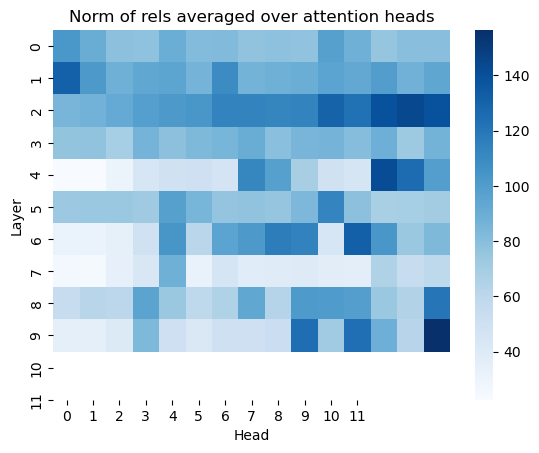

In [22]:
s = sns.heatmap(np.sum(norms, axis=2)[:10, :], xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Norm of rels averaged over attention heads")
plt.show()

## Basic local relevance sanity check

In [65]:
import functools
'''
ranges = [
        [layer for layer in range(1)], # only the input layer
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
'''

ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
target_nodes = []
out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)


In [18]:
import matplotlib
from IPython.core.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

def normalize_word_scores(word_scores):
    neg_pos_lst = [i for i, x in enumerate(word_scores) if x < 0]
    abs_word_scores = np.abs(word_scores)
    normalized = (abs_word_scores-min(abs_word_scores))/(max(abs_word_scores)-min(abs_word_scores)) # in [0, 1] range
    for i, x in enumerate(normalized):
        if i in neg_pos_lst:
            normalized[i] = -normalized[i]
    return normalized

def colorize(words, color_array, mid=0, eps=1e-03):
    cmap_pos = LinearSegmentedColormap.from_list('', ['white', '#48b6df'])
    cmap_neg = LinearSegmentedColormap.from_list('', ['white', '#dd735b'])
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        if color > mid:
          color = matplotlib.colors.rgb2hex(cmap_pos(color)[:3])
        elif color < mid:
          color = matplotlib.colors.rgb2hex(cmap_neg(abs(color))[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [19]:
def get_word_scores(out_decomps, ioi_dataset, data_idx):# calculate the "ioi score": the score of the correct logit minus the score of the subject logit
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab]
    io_seq_idx = ioi_dataset.io_tokenIDs[data_idx] 
    s_seq_idx = ioi_dataset.s_tokenIDs[data_idx] 

    io_logit = logits[0, -2, io_seq_idx]
    s_logit = logits[0, -2, s_seq_idx]
    full_score = np.abs(io_logit - s_logit)

    # for each source node determine the contribution of rel to the actual score
    rel_word_scores = []
    irrel_word_scores = []
    Result = collections.namedtuple('Result', ('ablation_set', 'score'))
    for idx, decomp in enumerate(out_decomps):
        assert(idx == decomp.ablation_set[0].sequence_idx)
        rel_io_logit = decomp.rel[0, -2, io_seq_idx]
        rel_s_logit = decomp.rel[0, -2, s_seq_idx]
        rel_score = rel_io_logit - rel_s_logit
        rel_norm_score = rel_score / full_score
        rel_word_scores.append(rel_norm_score)
        irrel_io_logit = decomp.irrel[0, -2, io_seq_idx]
        irrel_s_logit = decomp.irrel[0, -2, s_seq_idx]
        irrel_score = irrel_io_logit - irrel_s_logit
        irrel_norm_score = irrel_score / full_score
        irrel_word_scores.append(irrel_norm_score)
    irrel_word_scores = normalize_word_scores(irrel_word_scores)
    rel_word_scores = normalize_word_scores(rel_word_scores)
    return rel_word_scores, irrel_word_scores


In [21]:
for example_idx in range(10):
    ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
    target_nodes = []
    text = ioi_dataset.sentences[example_idx]
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                        device)
    out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
    rel_word_scores, irrel_word_scores = get_word_scores(out_decomps, ioi_dataset, example_idx)
    tokens = ioi_dataset.tokenized_prompts[example_idx].split('|')[:-1]
    s = colorize(tokens, rel_word_scores[:-1])
    print(rel_word_scores[:-1])
    # s = colorize(tokens, [r - i for (r, i) in zip(rel_word_scores, irrel_word_scores)])
    display(HTML(s))
    

[ 0.12503366  0.06804211 -0.2677273   0.2379223   1.          0.00652583
  0.02117849  0.0179997   0.02852546  0.04209874  0.0623992   0.1255095
  0.06398715  0.12358031  0.11079159]


[-0.1552476  -0.14887741 -0.6305817   0.05864168  1.         -0.06279838
 -0.0682397  -0.06820069 -0.02659738 -0.05016475  0.00791491 -0.02818444
 -0.04597878 -0.09961167 -0.04498641]


[ 0.0425189   0.03517073  1.         -0.09745114 -0.35051733  0.02604655
  0.02128902  0.02583591  0.06288438  0.03159104 -0.0043792   0.10695977
  0.04921279  0.12951623  0.09041143]


[ 0.18934785  0.15109085  1.         -0.0344139  -0.33849844  0.07406908
  0.05657801  0.04989342  0.09208179  0.06909477  0.09598547  0.17915249
  0.06734275  0.14801477  0.11576092]


[ 0.12946582  0.12280737  1.         -0.03613115 -0.25130832  0.05250986
  0.04029482  0.03867125  0.05197566  0.04712072  0.08957664  0.10962921
  0.06660286  0.13164486  0.1481048 ]


[ 0.1941418   0.1610752   1.         -0.02469452 -0.34211576  0.06260889
  0.04523696  0.05116198  0.03708613  0.08449797  0.08677364  0.11668406
  0.07921972  0.13993913  0.13289903]


[-0.01461308 -0.00864195 -0.5357655   0.16570593  1.          0.02826415
  0.03289288  0.03200421  0.06679868  0.01457724  0.02131403 -0.02401124
  0.04435056 -0.01204948  0.00950366]


[ 0.04435787  0.02368905 -0.57629335  0.19734778  1.          0.02564937
  0.03295699  0.02718469  0.02646942  0.01844267  0.06436802  0.04170526
  0.03486887  0.07007771  0.03576522]


[ 0.2518996   0.19492106 -0.06323055  0.3893512   1.          0.15954773
  0.13111773  0.1287994   0.1649629   0.14558947  0.23237486  0.2342385
  0.10641388  0.18450557  0.21194205]


[0.17261952 0.13571991 0.08110307 0.2937489  1.         0.08936537
 0.06979498 0.06000548 0.09124836 0.09228605 0.18397167 0.13137104
 0.05967544 0.12423955 0.07967421]


In [22]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [23]:
def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):] #bisect does a binary search, returns idx of outlier_score
    return outliers

In [61]:
results.sort(key=operator.attrgetter('score'), reverse=False)
iqr = interquartile_range(results)
print(len(iqr))
outliers = n_sigma_rule(results, n=0.5)
print(len(outliers))

0.0048643267 0.0020574331 0.007671220228075981
1
0.0033118916 0.0037320566 0.005388002377003431
1
